In [1]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import face3d
import trimesh
from face3d import mesh
from face3d.morphable_model import MorphabelModel

import ipywidgets as widgets

In [2]:
image_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.jpg'
mat_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.mat'
save_folder = 'single_results/posmap_300WLP_4995'

In [3]:
# uv_coords = face3d.morphable_model.load.load_uv_coords('Data/BFM/Out/BFM_UV.mat')
# uv_coords = process_uv(uv_coords, uv_h, uv_w)
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

In [4]:
info = sio.loadmat(mat_path)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)

In [5]:
faces = bfm.full_triangles

# Create a trimesh mesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

if not mesh.is_volume:
    print("Warning: The mesh is not a valid volume. This might affect proximity queries.")

In [6]:
mesh.show()

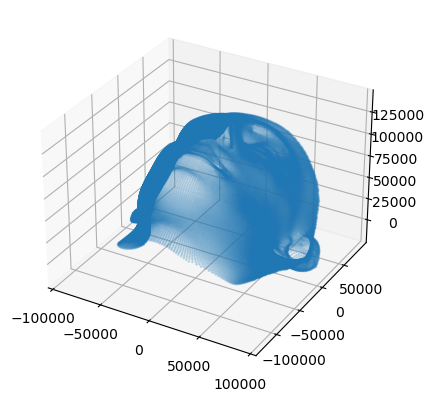

In [7]:
point_cloud = trimesh.points.PointCloud(vertices)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], s=1, alpha=0.2)
plt.show()

In [8]:
# Replace with the path to your BFM model file
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

shape_para = np.random.rand(bfm.n_shape_para, 1)  # Example shape parameters
exp_para = np.random.rand(bfm.n_exp_para, 1)      # Example expression parameters

# Generate vertices of the 3D face model
vertices = bfm.generate_vertices(shape_para, exp_para)

# Find the geometric center of the model
face_center = np.mean(vertices, axis=0)

z_offset = -15000

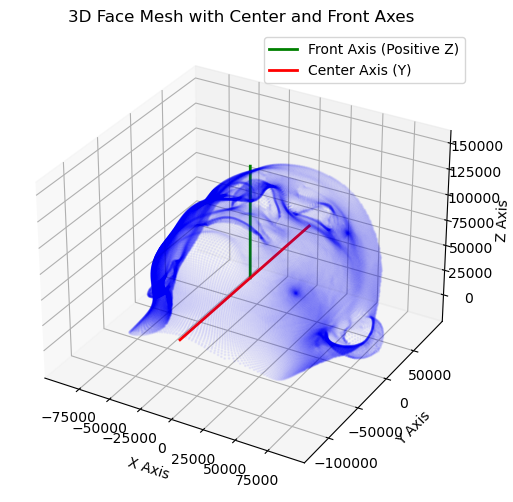

In [9]:
x, y, z = vertices[:,0], vertices[:,1], vertices[:,2]
center_x, center_y, center_z = face_center[0], face_center[1], face_center[2] + z_offset

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, color='blue', s=1, alpha=0.05)

# Plot the front-facing axis (positive z-axis)
z_front_min, z_front_max = center_z, 150000
ax.plot([center_x, center_x], [center_y, center_y], [z_front_min, z_front_max], color='green', linewidth=2, label='Front Axis (Positive Z)')

# Plot the center axis
ax.plot([center_x, center_x], [np.min(y), np.max(y)], [center_z, center_z], color='red', linewidth=2, label='Center Axis (Y)')

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Face Mesh with Center and Front Axes')
ax.legend()

plt.show()

In [10]:
def get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y):
    r, phi, y = cartesian_to_cylindrical_vertical_axis(vertex, face_center, z_offset)

    leftmost_phi = -np.pi/2
    rightmost_phi = np.pi/2
    if leftmost_phi <= phi <= rightmost_phi:
        phi_normalized = (phi - leftmost_phi) / (rightmost_phi - leftmost_phi)
        y_normalized = (y - min_y) / (max_y - min_y)

        i = int(phi_normalized * (res_phi - 1))
        j = res_y - 1 - int(y_normalized * (res_y - 1))

        return r, i, j
    else:
        return None

def map_position_to_vertex(i, j, r, face_center, z_offset, res_phi, res_y, min_y, max_y):
    # Denormalize the map coordinates
    phi_normalized = i / (res_phi - 1)
    y_normalized = 1 - j / (res_y - 1)

    # Convert normalized coordinates back to original phi and y
    phi = phi_normalized * (np.pi) - np.pi / 2
    y = y_normalized * (max_y - min_y) + min_y

    # Convert from cylindrical back to Cartesian coordinates
    x = np.cos(phi) * r + face_center[0]
    z = np.sin(phi) * r + face_center[2] + z_offset
    return x, y, z

def cartesian_to_cylindrical_vertical_axis(vertex, face_center, z_offset):
    x, z, y = vertex[0] - face_center[0], vertex[2] - (face_center[2] + z_offset), vertex[1]
    r = np.sqrt(x**2 + z**2)
    phi = np.arctan2(x, z)
    return r, phi, y

In [11]:
# initialize the radial map
res_phi, res_y = 512, 512  # Resolution of the cylindrical map, adjust as needed!
radial_map = np.zeros((res_y, res_phi))

In [12]:
# Precompute min and max y values for normalization
min_y, max_y = np.min(vertices[:,1]), np.max(vertices[:,1])

# Initialize the radial map
radial_map = np.zeros((res_y, res_phi))

# Populate the radial map
for vertex in vertices:
    result = get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y)
    
    if result is not None:
        r, i, j = result
        radial_map[j, i] = r

# Normalize the radial map for visualization
radial_map_normalized = (radial_map - np.min(radial_map)) / (np.max(radial_map) - np.min(radial_map))

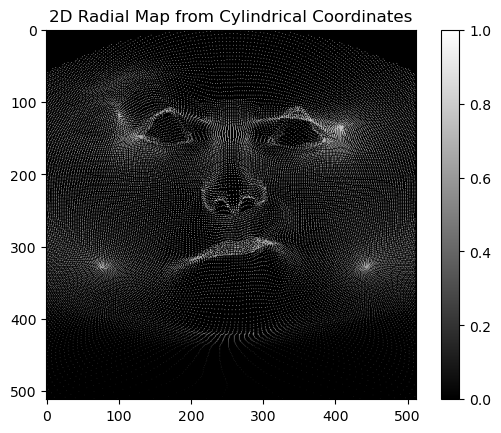

In [13]:
plt.imshow(radial_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [14]:
def find_bounding_box_and_vertices_of_triangle(triangle, face_center, z_offset, res_phi, res_y, min_y, max_y):
    min_i = res_phi - 1
    max_i = 0
    min_j = res_y - 1
    max_j = 0
    depths = []
    map_vertices = []

    for vertex in triangle:
        result = get_vertex_position_on_radial_map(vertex, face_center, z_offset, res_phi, res_y, min_y, max_y)
        
        if result is not None:
            r, i, j = result
            min_i = min(min_i, i)
            max_i = max(max_i, i)
            min_j = min(min_j, j)
            max_j = max(max_j, j)
            depths.append(r)
            map_vertices.append((i, j))

    # Check if there are exactly three valid vertices
    if len(depths) == 3 and len(map_vertices) == 3 and min_i <= max_i and min_j <= max_j:
        bounding_box = (min_i, max_i, min_j, max_j)
        return bounding_box, depths, map_vertices
    else:
        return None, None, None

In [15]:
def barycentric_coordinates(triangle_vertices, point):
    A, B, C = triangle_vertices
    v0 = B - A
    v1 = C - A
    v2 = point - A
    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)
    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w
    return u, v, w

def interpolate_depth_within_bounding_box(map_vertices, triangle_depths, bounding_box, res_phi, res_y):
    # Unpack the bounding box
    min_i, max_i, min_j, max_j = bounding_box

    # Create an array to hold the interpolated depths, sized to fit the bounding box
    bbox_height = max_j - min_j + 1
    bbox_width = max_i - min_i + 1
    interpolated_depths = np.zeros((bbox_height, bbox_width))

    tri_vertices = np.array([[v[0], v[1]] for v in map_vertices])

    for i in range(min_i, max_i + 1):
        for j in range(min_j, max_j + 1):
            # Compute Barycentric coordinates in the map coordinate system
            u, v, w = barycentric_coordinates(tri_vertices, (i, j))

            # Check if the point is inside the triangle
            if 0 <= u <= 1 and 0 <= v <= 1 and 0 <= w <= 1:
                # Interpolate the depth value
                interpolated_depth = triangle_depths[0] * u + triangle_depths[1] * v + triangle_depths[2] * w
                interpolated_depths[j - min_j, i - min_i] = interpolated_depth

    return interpolated_depths




In [16]:
faces = bfm.full_triangles

In [17]:
interpolated_map_normalized = np.zeros((res_y, res_phi))
for triangle_indices in faces:
    triangle_vertices = [vertices[index] for index in triangle_indices]
    bbox, triangle_depths, triangle_map_vertices = find_bounding_box_and_vertices_of_triangle(triangle_vertices, face_center, z_offset, res_phi, res_y, min_y, max_y)
    if bbox is None:
        continue

    interpolated_map = interpolate_depth_within_bounding_box(triangle_map_vertices, triangle_depths, bbox, res_phi, res_y)
    
    min_i, max_i, min_j, max_j = bbox
    for i in range(min_i, max_i + 1):
            for j in range(min_j, max_j + 1):
                depth = interpolated_map[j - min_j, i - min_i]
                if depth > interpolated_map_normalized[j, i]:
                    interpolated_map_normalized[j, i] = depth

C:\Users\chenb\AppData\Local\Temp\ipykernel_34084\210135292.py:12: RuntimeWarning: invalid value encountered in scalar divide
  v = (d11 * d20 - d01 * d21) / denom
C:\Users\chenb\AppData\Local\Temp\ipykernel_34084\210135292.py:13: RuntimeWarning: invalid value encountered in scalar divide
  w = (d00 * d21 - d01 * d20) / denom


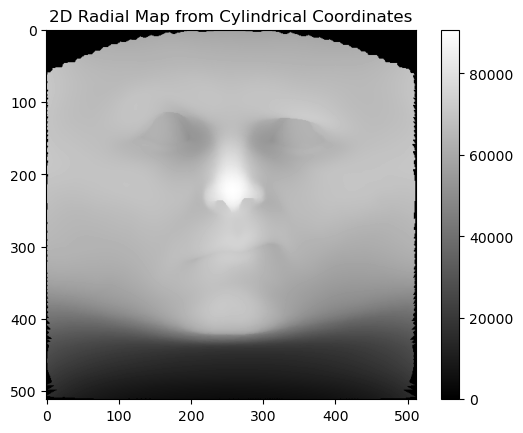

In [18]:
plt.imshow(interpolated_map_normalized, cmap='gray')
plt.colorbar()
plt.title("2D Radial Map from Cylindrical Coordinates")
plt.show()

In [19]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = radial_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * np.pi - np.pi / 2
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi)
        reconstructed_vertices.append([x, y, z])

reconstructed_vertices = np.array(reconstructed_vertices)


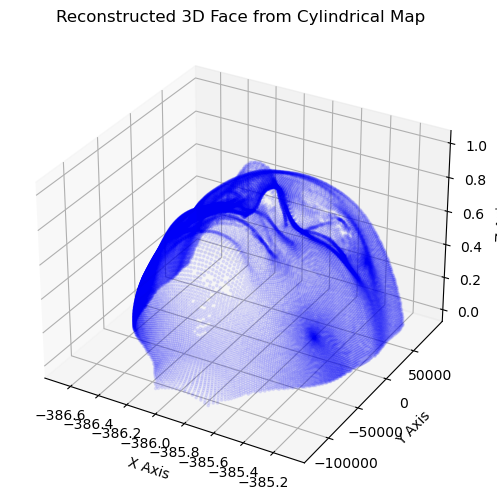

In [20]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices[:,0], reconstructed_vertices[:,1], reconstructed_vertices[:,2], color='blue', s=3, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map')
# ax.view_init(elev=90, azim=270)
plt.show()


In [21]:
# Initialize an array to hold the reconstructed vertices
reconstructed_vertices_interpolated = []

# Iterate over the 2D map
for j in range(res_y):
    for i in range(res_phi):
        # Retrieve the radius value from the interpolated map
        r = interpolated_map_normalized[j, i]

        # Skip points where the radius is zero
        if r == 0:
            continue

        # Reverse the normalization of the azimuthal angle and y-coordinate
        phi = (i / (res_phi - 1)) * np.pi - np.pi / 2
        y = np.max(vertices[:,1]) - (j / (res_y - 1)) * (np.max(vertices[:,1]) - np.min(vertices[:,1]))

        # Convert back to Cartesian coordinates
        x = r * np.sin(phi) + center_x
        z = r * np.cos(phi)
        reconstructed_vertices_interpolated.append([x, y, z])

reconstructed_vertices_interpolated = np.array(reconstructed_vertices_interpolated)

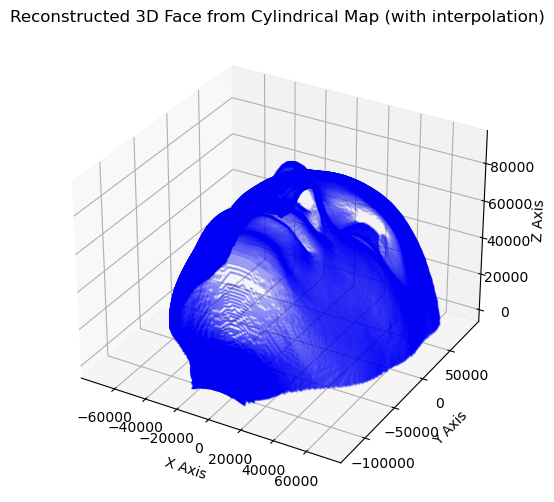

In [22]:
# Plotting the reconstructed vertices
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(reconstructed_vertices_interpolated[:,0], reconstructed_vertices_interpolated[:,1], reconstructed_vertices_interpolated[:,2], color='blue', s=1, alpha=0.08)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map (with interpolation)')
# ax.view_init(elev=90, azim=270)
plt.show()

In [23]:
def crop_and_shift_mesh(vertices, faces, z_offset):
    """
    Efficiently crop a mesh at a specified Z offset and shift it to z=0.

    :param vertices: Nx3 numpy array of vertices.
    :param faces: Mx3 numpy array of faces (indices into vertices).
    :param z_offset: Z value at which to crop the mesh.
    :return: Cropped and shifted vertices and faces.
    """
    # Filter vertices below the z_offset
    valid_vertices_mask = vertices[:, 2] >= z_offset
    cropped_vertices = vertices[valid_vertices_mask]

    # Shift the mesh so the base lies at z=0
    min_z = np.min(cropped_vertices[:, 2])
    cropped_vertices[:, 2] -= min_z

    # Create a mapping from old vertex indices to new indices
    index_mapping = np.full(vertices.shape[0], -1, dtype=int)
    index_mapping[valid_vertices_mask] = np.arange(cropped_vertices.shape[0])

    # Update faces
    mapped_faces = index_mapping[faces]
    valid_faces_mask = np.all(mapped_faces >= 0, axis=1)
    cropped_faces = mapped_faces[valid_faces_mask]

    return cropped_vertices, cropped_faces

cropped_vertices, cropped_faces = crop_and_shift_mesh(vertices, faces, center_z)

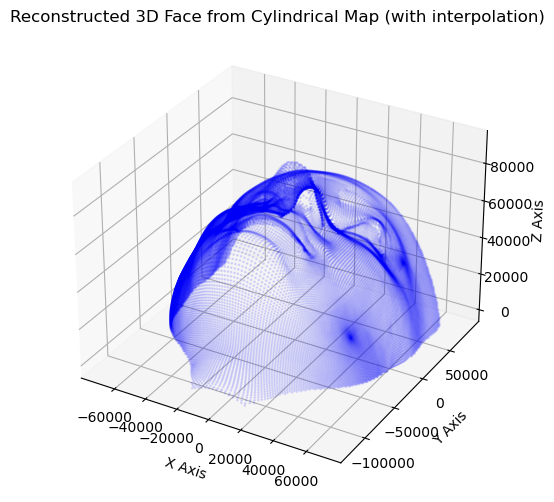

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Assuming reconstructed_vertices contains [x, y, z] coordinates
ax.scatter(cropped_vertices[:,0], cropped_vertices[:,1], cropped_vertices[:,2], color='blue', s=1, alpha=0.1)

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Reconstructed 3D Face from Cylindrical Map (with interpolation)')
# ax.view_init(elev=90, azim=270)
plt.show()

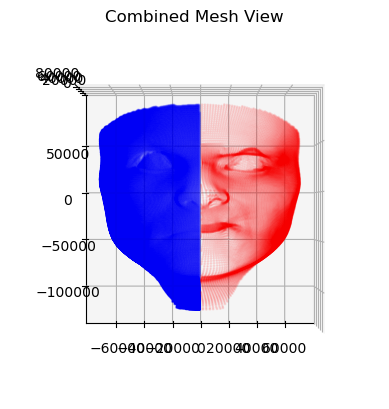

In [25]:
%matplotlib inline

# Assuming scaled_reconstructed and scaled_shifted are already defined
# Split the models in half (modify the condition as per your model's orientation)
half_index_reconstructed = np.median(reconstructed_vertices_interpolated[:, 0])
half_index_shifted = np.median(cropped_vertices[:, 0])

# Use only half of each model
half_reconstructed = reconstructed_vertices_interpolated[reconstructed_vertices_interpolated[:, 0] <= half_index_reconstructed]
half_shifted = cropped_vertices[cropped_vertices[:, 0] > half_index_shifted]

# Combine the halves
combined_vertices = np.vstack((half_reconstructed, half_shifted))

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the combined mesh
ax.scatter(half_reconstructed[:, 0], half_reconstructed[:, 1], half_reconstructed[:, 2], s=1, alpha=0.06, color='blue')
ax.scatter(half_shifted[:, 0], half_shifted[:, 1], half_shifted[:, 2], s=1, alpha=0.1, color='red')

# Set the view angle
ax.view_init(elev=90, azim=270)

ax.set_title("Combined Mesh View")

plt.show()

In [26]:
def calculate_point_to_surface_distances(mesh_vertices, mesh_faces, point_cloud):
    # Create a trimesh object from the mesh
    mesh = trimesh.Trimesh(vertices=mesh_vertices, faces=mesh_faces, process=False)

    # Use trimesh's nearest.on_surface to find the closest point on the mesh for each point in the point cloud
    closest_points, distances, _ = trimesh.proximity.closest_point(mesh, point_cloud)

    return distances

In [27]:
distances = calculate_point_to_surface_distances(cropped_vertices, cropped_faces, reconstructed_vertices_interpolated)

In [28]:
# Calculate statistics
mean_distance = np.mean(distances)
median_distance = np.median(distances)
std_distance = np.std(distances)
hausdorff_distance = distances.max()

print(f"Mean Distance: {mean_distance}")
print(f"Median Distance: {median_distance}")
print(f"Standard Deviation: {std_distance}")
print(f"Hausdorff Distance: {hausdorff_distance}")

Mean Distance: 77.57740479431646
Median Distance: 58.670305476290935
Standard Deviation: 66.37626329161687
Hausdorff Distance: 583.8553219861901


In [29]:
from mpl_toolkits.mplot3d import Axes3D

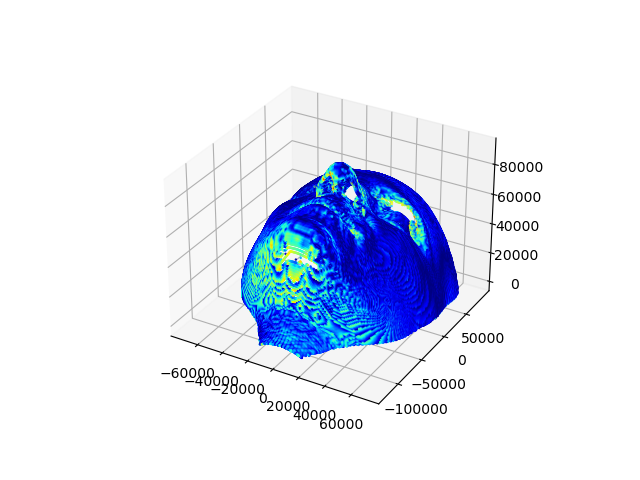

In [30]:
%matplotlib widget

normalized_distances = (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

# Create a scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reconstructed_vertices_interpolated[:, 0], reconstructed_vertices_interpolated[:, 1], reconstructed_vertices_interpolated[:, 2], c=normalized_distances, cmap='jet', s=0.5)

plt.show()
